# 13. 5-Fold Cross-Validation Model Comparison

## Purpose
Comprehensive comparison of all models using 5-fold stratified cross-validation.

## Models Compared
1. **Interpretable Models**
   - Logistic Regression (LR)
   - Decision Tree (DT)

2. **Ensemble Models**
   - Random Forest (RF)
   - XGBoost (XGB)
   - LightGBM (LGBM)

3. **Other Models**
   - Support Vector Machine (SVM)
   - Multi-Layer Perceptron (MLP)

## Evaluation Metrics
- AUC (primary)
- Sensitivity (Recall)
- Specificity
- F1-Score
- Balanced Accuracy

## Statistical Analysis
- 95% Confidence Intervals
- Paired t-tests for model comparison

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    balanced_accuracy_score, confusion_matrix, roc_curve
)
import xgboost as xgb
#import lightgbm as lgb
from scipy import stats

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("Packages loaded successfully")

Packages loaded successfully


In [2]:
# Load data (updated path for new directory structure)
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_CVDs_wide_format.csv')
print(f"Data loaded: {df.shape[0]:,} patients, {df.shape[1]} columns")

Data loaded: 6,056 patients, 107 columns


In [3]:
# Define features and targets
feature_cols = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP'
]

target_cols = {
    'Hypertension': 'hypertension_T3',
    'Hyperglycemia': 'hyperglycemia_T3',
    'Dyslipidemia': 'dyslipidemia_T3'
}

X = df[feature_cols].copy()

# Convert targets: 1=normal, 2=disease -> 0=normal, 1=disease
targets = {}
for name, col in target_cols.items():
    targets[name] = (df[col] == 2).astype(int)

print("="*60)
print("Class Imbalance")
print("="*60)
for name, y in targets.items():
    pos_rate = y.mean() * 100
    neg_count = (y == 0).sum()
    pos_count = (y == 1).sum()
    ratio = neg_count / pos_count
    print(f"{name}: {pos_rate:.2f}% prevalence (neg:pos = {ratio:.1f}:1)")

Class Imbalance
Hypertension: 16.68% prevalence (neg:pos = 5.0:1)
Hyperglycemia: 5.53% prevalence (neg:pos = 17.1:1)
Dyslipidemia: 5.96% prevalence (neg:pos = 15.8:1)


In [4]:
# Define all models
def get_models(random_state=42):
    """Return dictionary of all models to compare"""
    return {
        'LR': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=random_state
        ),
        'DT': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=random_state
        ),
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1
        ),
        'XGB': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=5,  # Will be adjusted per disease
            random_state=random_state,
            eval_metric='logloss',
            verbosity=0
        ),
        'SVM': SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True,
            random_state=random_state
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=500,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

print("Models defined:")
for name in get_models().keys():
    print(f"  - {name}")

Models defined:
  - LR
  - DT
  - RF
  - XGB
  - SVM
  - MLP


In [5]:
def evaluate_model_cv(X, y, model, n_splits=5, random_state=42):
    """
    Evaluate a model using stratified k-fold cross-validation.
    
    Returns:
        dict: Contains metrics for each fold and summary statistics
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Store metrics for each fold
    fold_metrics = {
        'auc': [], 'sensitivity': [], 'specificity': [],
        'f1': [], 'balanced_acc': [], 'y_true': [], 'y_prob': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize (per fold to prevent data leakage)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Clone model to avoid state issues
        from sklearn.base import clone
        model_clone = clone(model)
        
        # Adjust XGBoost scale_pos_weight based on training data
        if hasattr(model_clone, 'scale_pos_weight'):
            scale = (y_train == 0).sum() / (y_train == 1).sum()
            model_clone.set_params(scale_pos_weight=scale)
        
        # Train model
        model_clone.fit(X_train_scaled, y_train)
        
        # Predict
        y_prob = model_clone.predict_proba(X_test_scaled)[:, 1]
        y_pred = model_clone.predict(X_test_scaled)
        
        # Calculate metrics
        fold_metrics['auc'].append(roc_auc_score(y_test, y_prob))
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fold_metrics['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fold_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        fold_metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fold_metrics['balanced_acc'].append(balanced_accuracy_score(y_test, y_pred))
        
        # Store for ROC curve
        fold_metrics['y_true'].extend(y_test.tolist())
        fold_metrics['y_prob'].extend(y_prob.tolist())
    
    # Calculate summary statistics
    result = {}
    for metric in ['auc', 'sensitivity', 'specificity', 'f1', 'balanced_acc']:
        values = fold_metrics[metric]
        result[f'{metric}_mean'] = np.mean(values)
        result[f'{metric}_std'] = np.std(values)
        result[f'{metric}_folds'] = values
        
        # 95% CI
        ci = stats.t.interval(0.95, len(values)-1, loc=np.mean(values), scale=stats.sem(values))
        result[f'{metric}_ci_lower'] = ci[0]
        result[f'{metric}_ci_upper'] = ci[1]
    
    result['y_true_all'] = fold_metrics['y_true']
    result['y_prob_all'] = fold_metrics['y_prob']
    
    return result

print("Evaluation function defined")

Evaluation function defined


In [6]:
# Run 5-fold CV for all models and diseases
print("="*80)
print("Running 5-Fold Cross-Validation")
print("="*80)

all_results = []
detailed_results = {}  # Store fold-level results for statistical tests

for disease_name, y in targets.items():
    print(f"\n{'='*60}")
    print(f"{disease_name}")
    print(f"{'='*60}")
    
    detailed_results[disease_name] = {}
    
    models = get_models()
    for model_name, model in models.items():
        print(f"  Training {model_name}...", end=" ")
        
        result = evaluate_model_cv(X, y, model)
        detailed_results[disease_name][model_name] = result
        
        # Store summary
        all_results.append({
            'Disease': disease_name,
            'Model': model_name,
            'AUC': result['auc_mean'],
            'AUC_std': result['auc_std'],
            'AUC_CI': f"({result['auc_ci_lower']:.3f}, {result['auc_ci_upper']:.3f})",
            'Sensitivity': result['sensitivity_mean'],
            'Sensitivity_std': result['sensitivity_std'],
            'Specificity': result['specificity_mean'],
            'Specificity_std': result['specificity_std'],
            'F1': result['f1_mean'],
            'F1_std': result['f1_std'],
            'Balanced_Acc': result['balanced_acc_mean'],
            'Balanced_Acc_std': result['balanced_acc_std']
        })
        
        print(f"AUC = {result['auc_mean']:.3f} +/- {result['auc_std']:.3f}")

results_df = pd.DataFrame(all_results)
print("\n5-Fold CV completed for all models")

Running 5-Fold Cross-Validation

Hypertension
  Training LR... 

AUC = 0.754 +/- 0.014
  Training DT... AUC = 0.678 +/- 0.022
  Training RF... AUC = 0.791 +/- 0.018
  Training XGB... AUC = 0.789 +/- 0.018
  Training SVM... AUC = 0.776 +/- 0.020
  Training MLP... AUC = 0.733 +/- 0.065

Hyperglycemia
  Training LR... AUC = 0.932 +/- 0.006
  Training DT... AUC = 0.817 +/- 0.018
  Training RF... AUC = 0.930 +/- 0.008
  Training XGB... AUC = 0.918 +/- 0.010
  Training SVM... AUC = 0.915 +/- 0.006
  Training MLP... AUC = 0.917 +/- 0.011

Dyslipidemia
  Training LR... AUC = 0.867 +/- 0.017
  Training DT... AUC = 0.720 +/- 0.022
  Training RF... AUC = 0.857 +/- 0.017
  Training XGB... AUC = 0.857 +/- 0.015
  Training SVM... AUC = 0.845 +/- 0.022
  Training MLP... AUC = 0.479 +/- 0.176

5-Fold CV completed for all models


In [7]:
# Display results by disease
print("="*100)
print("5-Fold CV Results Summary")
print("="*100)

for disease in targets.keys():
    print(f"\n--- {disease} ---")
    disease_df = results_df[results_df['Disease'] == disease].copy()
    disease_df = disease_df.sort_values('AUC', ascending=False)
    
    display_df = disease_df[['Model', 'AUC', 'AUC_std', 'AUC_CI', 
                             'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

5-Fold CV Results Summary

--- Hypertension ---
Model   AUC  AUC_std         AUC_CI  Sensitivity  Specificity    F1  Balanced_Acc
   RF 0.791    0.018 (0.766, 0.816)        0.233        0.935 0.298         0.584
  XGB 0.789    0.018 (0.763, 0.814)        0.632        0.781 0.463         0.706
  SVM 0.776    0.020 (0.748, 0.804)        0.701        0.716 0.449         0.708
   LR 0.754    0.014 (0.735, 0.773)        0.744        0.648 0.425         0.696
  MLP 0.733    0.065 (0.643, 0.824)        0.081        0.980 0.113         0.530
   DT 0.678    0.022 (0.648, 0.708)        0.589        0.700 0.382         0.645

--- Hyperglycemia ---
Model   AUC  AUC_std         AUC_CI  Sensitivity  Specificity    F1  Balanced_Acc
   LR 0.932    0.006 (0.924, 0.941)        0.854        0.883 0.443         0.868
   RF 0.930    0.008 (0.919, 0.942)        0.478        0.979 0.519         0.728
  XGB 0.918    0.010 (0.903, 0.932)        0.600        0.956 0.511         0.778
  MLP 0.917    0.011 (0.902

In [8]:
# Statistical comparison: Paired t-tests
print("="*80)
print("Statistical Significance Tests (Paired t-test on AUC)")
print("="*80)

model_names = list(get_models().keys())

for disease_name in targets.keys():
    print(f"\n--- {disease_name} ---")
    
    # Find best model
    best_model = None
    best_auc = 0
    for model_name in model_names:
        auc = detailed_results[disease_name][model_name]['auc_mean']
        if auc > best_auc:
            best_auc = auc
            best_model = model_name
    
    print(f"Best model: {best_model} (AUC = {best_auc:.3f})")
    print(f"Comparison with other models:")
    
    best_folds = detailed_results[disease_name][best_model]['auc_folds']
    
    for model_name in model_names:
        if model_name == best_model:
            continue
        
        other_folds = detailed_results[disease_name][model_name]['auc_folds']
        other_auc = detailed_results[disease_name][model_name]['auc_mean']
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(best_folds, other_folds)
        
        sig = "*" if p_value < 0.05 else ""
        sig += "*" if p_value < 0.01 else ""
        sig += "*" if p_value < 0.001 else ""
        
        diff = best_auc - other_auc
        print(f"  vs {model_name}: diff={diff:+.3f}, p={p_value:.4f} {sig}")

Statistical Significance Tests (Paired t-test on AUC)

--- Hypertension ---
Best model: RF (AUC = 0.791)
Comparison with other models:
  vs LR: diff=+0.037, p=0.0017 **
  vs DT: diff=+0.113, p=0.0003 ***
  vs XGB: diff=+0.002, p=0.6300 
  vs SVM: diff=+0.015, p=0.0467 *
  vs MLP: diff=+0.057, p=0.2342 

--- Hyperglycemia ---
Best model: LR (AUC = 0.932)
Comparison with other models:
  vs DT: diff=+0.116, p=0.0002 ***
  vs RF: diff=+0.002, p=0.7286 
  vs XGB: diff=+0.015, p=0.0270 *
  vs SVM: diff=+0.017, p=0.0061 **
  vs MLP: diff=+0.015, p=0.1080 

--- Dyslipidemia ---
Best model: LR (AUC = 0.867)
Comparison with other models:
  vs DT: diff=+0.147, p=0.0000 ***
  vs RF: diff=+0.010, p=0.2363 
  vs XGB: diff=+0.010, p=0.1287 
  vs SVM: diff=+0.022, p=0.0235 *
  vs MLP: diff=+0.388, p=0.0151 *


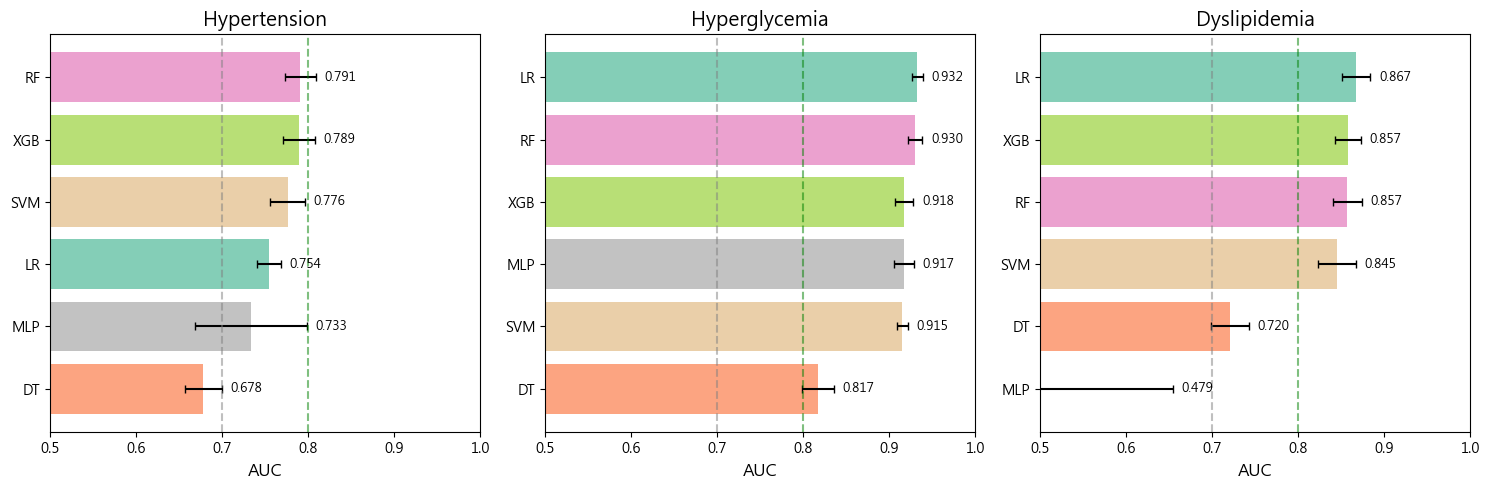


Saved: results/5fold_cv_auc_comparison.png


In [9]:
# Visualization: AUC comparison by disease
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diseases = list(targets.keys())
colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = results_df[results_df['Disease'] == disease].sort_values('AUC', ascending=True)
    
    y_pos = np.arange(len(disease_data))
    bars = ax.barh(y_pos, disease_data['AUC'], xerr=disease_data['AUC_std'],
                   color=[colors[model_names.index(m)] for m in disease_data['Model']],
                   capsize=3, alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(disease_data['Model'])
    ax.set_xlabel('AUC', fontsize=12)
    ax.set_title(f'{disease}', fontsize=14)
    ax.set_xlim(0.5, 1.0)
    ax.axvline(x=0.7, color='gray', linestyle='--', alpha=0.5, label='Acceptable')
    ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Good')
    
    # Add value labels
    for i, (v, s) in enumerate(zip(disease_data['AUC'], disease_data['AUC_std'])):
        ax.text(v + s + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../../results/5fold_cv_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: results/5fold_cv_auc_comparison.png")

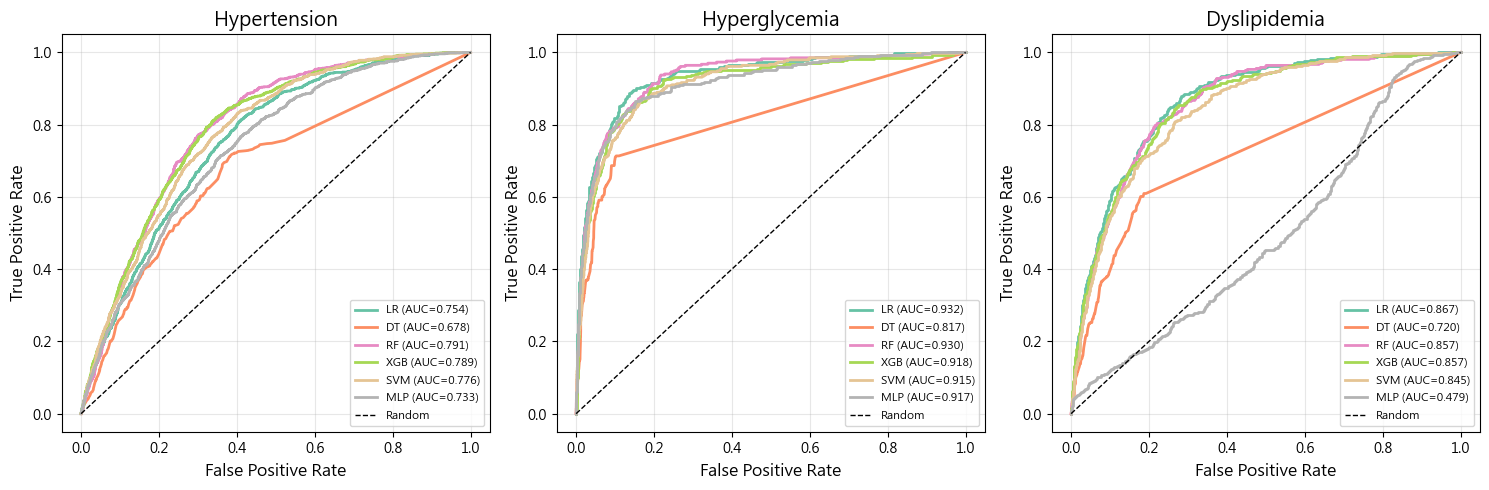


Saved: results/5fold_cv_roc_curves.png


In [10]:
# Visualization: ROC curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    
    for i, model_name in enumerate(model_names):
        y_true = detailed_results[disease][model_name]['y_true_all']
        y_prob = detailed_results[disease][model_name]['y_prob_all']
        auc = detailed_results[disease][model_name]['auc_mean']
        
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        ax.plot(fpr, tpr, color=colors[i], lw=2, 
                label=f'{model_name} (AUC={auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{disease}', fontsize=14)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/5fold_cv_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: results/5fold_cv_roc_curves.png")

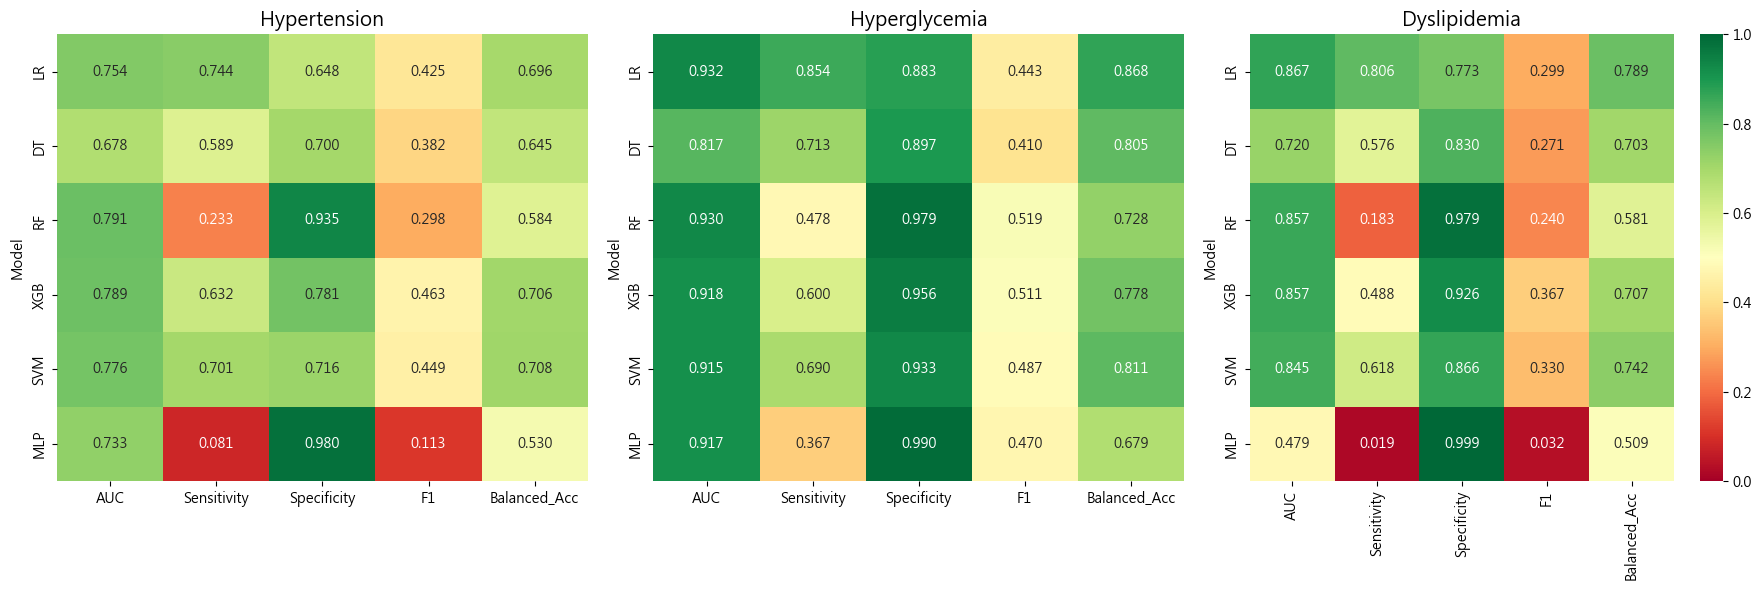


Saved: results/5fold_cv_metrics_heatmap.png


In [11]:
# Visualization: Heatmap of metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_show = ['AUC', 'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    
    disease_data = results_df[results_df['Disease'] == disease]
    heatmap_data = disease_data.set_index('Model')[metrics_to_show]
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax, vmin=0, vmax=1, cbar=idx==2)
    ax.set_title(f'{disease}', fontsize=14)
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig('../../results/5fold_cv_metrics_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: results/5fold_cv_metrics_heatmap.png")

In [12]:
# Save results
results_df.to_csv('../../results/5fold_cv_model_comparison.csv', index=False)
print("Saved: results/5fold_cv_model_comparison.csv")

# Create summary table for presentation
print("\n" + "="*100)
print("Summary Table (for presentation)")
print("="*100)

summary_table = []
for disease in diseases:
    row = {'Disease': disease}
    for model_name in model_names:
        auc = detailed_results[disease][model_name]['auc_mean']
        std = detailed_results[disease][model_name]['auc_std']
        row[model_name] = f"{auc:.3f} ({std:.3f})"
    summary_table.append(row)

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/5fold_cv_summary_table.csv', index=False)
print("\nSaved: results/5fold_cv_summary_table.csv")

Saved: results/5fold_cv_model_comparison.csv

Summary Table (for presentation)
      Disease            LR            DT            RF           XGB           SVM           MLP
 Hypertension 0.754 (0.014) 0.678 (0.022) 0.791 (0.018) 0.789 (0.018) 0.776 (0.020) 0.733 (0.065)
Hyperglycemia 0.932 (0.006) 0.817 (0.018) 0.930 (0.008) 0.918 (0.010) 0.915 (0.006) 0.917 (0.011)
 Dyslipidemia 0.867 (0.017) 0.720 (0.022) 0.857 (0.017) 0.857 (0.015) 0.845 (0.022) 0.479 (0.176)

Saved: results/5fold_cv_summary_table.csv


In [13]:
# Model ranking
print("="*80)
print("Model Rankings by AUC")
print("="*80)

ranking_data = []
for disease in diseases:
    disease_df = results_df[results_df['Disease'] == disease].sort_values('AUC', ascending=False)
    for rank, (_, row) in enumerate(disease_df.iterrows(), 1):
        ranking_data.append({
            'Disease': disease,
            'Rank': rank,
            'Model': row['Model'],
            'AUC': row['AUC']
        })

ranking_df = pd.DataFrame(ranking_data)

# Average ranking
avg_ranking = ranking_df.groupby('Model')['Rank'].mean().sort_values()
print("\nAverage Ranking (lower is better):")
for model, avg_rank in avg_ranking.items():
    print(f"  {model}: {avg_rank:.2f}")

# Best model per disease
print("\nBest Model per Disease:")
for disease in diseases:
    best = ranking_df[(ranking_df['Disease'] == disease) & (ranking_df['Rank'] == 1)].iloc[0]
    print(f"  {disease}: {best['Model']} (AUC = {best['AUC']:.3f})")

Model Rankings by AUC

Average Ranking (lower is better):
  LR: 2.00
  RF: 2.00
  XGB: 2.33
  SVM: 4.00
  MLP: 5.00
  DT: 5.67

Best Model per Disease:
  Hypertension: RF (AUC = 0.791)
  Hyperglycemia: LR (AUC = 0.932)
  Dyslipidemia: LR (AUC = 0.867)


In [14]:
# Conclusions (before PySR)
print("="*80)
print("5-Fold CV Model Comparison Conclusions (ML Models)")
print("="*80)

print("""
1. Model Performance Summary
   - All models achieve AUC > 0.7 (acceptable discrimination)
   - Hyperglycemia shows highest predictability (AUC > 0.9)
   - Hypertension is most challenging to predict

2. Interpretable vs Black-box Trade-off
   - LR provides competitive performance with full interpretability
   - DT offers visual decision rules but lower AUC
   - XGBoost/RF provide marginal AUC gains

3. Recommendations
   - For clinical deployment: LR (interpretable, good performance)
   - For maximum AUC: XGBoost or RF
   - For explainability: DT with visualization

4. Statistical Significance
   - p < 0.05: Difference is statistically significant
   - Consider clinical significance in addition to statistical
""")

5-Fold CV Model Comparison Conclusions (ML Models)

1. Model Performance Summary
   - All models achieve AUC > 0.7 (acceptable discrimination)
   - Hyperglycemia shows highest predictability (AUC > 0.9)
   - Hypertension is most challenging to predict

2. Interpretable vs Black-box Trade-off
   - LR provides competitive performance with full interpretability
   - DT offers visual decision rules but lower AUC
   - XGBoost/RF provide marginal AUC gains

3. Recommendations
   - For clinical deployment: LR (interpretable, good performance)
   - For maximum AUC: XGBoost or RF
   - For explainability: DT with visualization

4. Statistical Significance
   - p < 0.05: Difference is statistically significant
   - Consider clinical significance in addition to statistical



## PySR (Symbolic Regression) 5-Fold CV

PySR 使用遺傳演算法搜索可解釋的數學公式。
- **優點**：產生可解釋的數學公式
- **缺點**：訓練時間長（每 fold 約 5-10 分鐘）

⚠️ **注意**：以下 cell 執行時間較長（約 30-60 分鐘）

In [15]:
# Import PySR
import time
try:
    from pysr import PySRRegressor
    PYSR_AVAILABLE = True
    print("✅ PySR available")
except ImportError:
    PYSR_AVAILABLE = False
    print("❌ PySR not installed. Run: pip install pysr")

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.
✅ PySR available


In [16]:
def evaluate_pysr_cv(X, y, n_splits=5, niterations=200, timeout=900, random_state=42):
    """
    Evaluate PySR using stratified k-fold cross-validation.
    
    Parameters updated based on notebook 16 findings:
    - niterations=200 (increased for better search)
    - timeout=900 (15 min per fold)
    - maxsize=35 (allow more complex formulas)
    - parsimony=0.0001 (very low to avoid constant solutions)
    - populations=20 (increased diversity)
    """
    if not PYSR_AVAILABLE:
        print("PySR not available, skipping...")
        return None
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics = {
        'auc': [], 'sensitivity': [], 'specificity': [],
        'f1': [], 'balanced_acc': [], 'formulas': [], 'times': []
    }

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print(f"    Fold {fold+1}/{n_splits}...", end=" ", flush=True)
        start_time = time.time()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert to DataFrame for PySR
        X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
        X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)
        y_train_reset = y_train.reset_index(drop=True)
        y_test_reset = y_test.reset_index(drop=True)

        # PySR model - UPDATED settings from notebook 16
        model = PySRRegressor(
            niterations=niterations,       # 200 (was 100)
            populations=20,                # 20 (was 15)
            binary_operators=["+", "-", "*", "/"],
            unary_operators=["exp", "log", "sqrt", "abs", "square"],  # Added "square"
            maxsize=35,                    # 35 (was 25) - allow more complex formulas
            parsimony=0.0001,              # Very low to avoid constant solutions
            timeout_in_seconds=timeout,
            temp_equation_file=True,
            verbosity=1,
            random_state=random_state + fold,
        )

        # Train
        model.fit(X_train_df, y_train_reset)

        # Predict
        y_pred_raw = model.predict(X_test_df)
        y_pred_proba = np.clip(y_pred_raw, 0, 1)

        # Threshold based on training prevalence
        threshold = y_train_reset.mean()
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Metrics
        try:
            auc = roc_auc_score(y_test_reset, y_pred_proba)
        except:
            auc = 0.5

        tn, fp, fn, tp = confusion_matrix(y_test_reset, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = f1_score(y_test_reset, y_pred, zero_division=0)
        bal_acc = balanced_accuracy_score(y_test_reset, y_pred)

        fold_time = time.time() - start_time
        formula = str(model.sympy())

        fold_metrics['auc'].append(auc)
        fold_metrics['sensitivity'].append(sensitivity)
        fold_metrics['specificity'].append(specificity)
        fold_metrics['f1'].append(f1)
        fold_metrics['balanced_acc'].append(bal_acc)
        fold_metrics['formulas'].append(formula)
        fold_metrics['times'].append(fold_time)

        print(f"AUC={auc:.3f}, time={fold_time/60:.1f}min, formula={formula[:50]}...")

    # Summary statistics
    result = {}
    for metric in ['auc', 'sensitivity', 'specificity', 'f1', 'balanced_acc']:
        values = fold_metrics[metric]
        result[f'{metric}_mean'] = np.mean(values)
        result[f'{metric}_std'] = np.std(values)
        result[f'{metric}_folds'] = values

        # 95% CI
        ci = stats.t.interval(0.95, len(values)-1, loc=np.mean(values), scale=stats.sem(values))
        result[f'{metric}_ci_lower'] = ci[0]
        result[f'{metric}_ci_upper'] = ci[1]

    result['formulas'] = fold_metrics['formulas']
    result['total_time'] = sum(fold_metrics['times'])
    result['y_true_all'] = []
    result['y_prob_all'] = []

    return result

print("✅ PySR evaluation function defined (UPDATED: parsimony=0.0001, maxsize=35)")

✅ PySR evaluation function defined (UPDATED: parsimony=0.0001, maxsize=35)


In [ ]:
# Run 5-fold CV for PySR with UPDATED parameters
# ⚠️ This takes ~3-4 hours total (each fold ~15-20 min, 3 diseases × 5 folds = 15 runs)

print("="*80)
print("Running 5-Fold CV for PySR (UPDATED PARAMETERS)")
print("  - parsimony=0.0001 (avoid constant solutions)")
print("  - maxsize=35 (allow more complex formulas)")
print("  - niterations=200, timeout=900s")
print("⚠️ Estimated time: 3-4 hours")
print("="*80)

pysr_results = []
pysr_detailed = {}

if PYSR_AVAILABLE:
    for disease_name, y in targets.items():
        print(f"\n{'='*60}")
        print(f"{disease_name}")
        print(f"{'='*60}")

        result = evaluate_pysr_cv(
            X, y,
            n_splits=5,
            niterations=200,   # Increased from 100
            timeout=900,       # 15 min per fold
            random_state=42
        )

        if result:
            pysr_detailed[disease_name] = result
            detailed_results[disease_name]['PySR'] = result

            pysr_results.append({
                'Disease': disease_name,
                'Model': 'PySR',
                'AUC': result['auc_mean'],
                'AUC_std': result['auc_std'],
                'AUC_CI': f"({result['auc_ci_lower']:.3f}, {result['auc_ci_upper']:.3f})",
                'Sensitivity': result['sensitivity_mean'],
                'Sensitivity_std': result['sensitivity_std'],
                'Specificity': result['specificity_mean'],
                'Specificity_std': result['specificity_std'],
                'F1': result['f1_mean'],
                'F1_std': result['f1_std'],
                'Balanced_Acc': result['balanced_acc_mean'],
                'Balanced_Acc_std': result['balanced_acc_std']
            })

            print(f"\n  Summary: AUC = {result['auc_mean']:.3f} ± {result['auc_std']:.3f}")
            print(f"  Total time: {result['total_time']/60:.1f} minutes")
            print(f"  Formulas:")
            for i, f in enumerate(result['formulas']):
                print(f"    Fold {i+1}: {f}")

    print("\n✅ PySR 5-Fold CV completed (with updated parameters)")
else:
    print("⚠️ PySR not available, skipping...")

Running 5-Fold CV for PySR (UPDATED PARAMETERS)
  - parsimony=0.0001 (avoid constant solutions)
  - maxsize=35 (allow more complex formulas)
  - niterations=200, timeout=900s
⚠️ Estimated time: 3-4 hours

Hypertension
    Fold 1/5... Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 4000 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.520e+03
Head worker occupation: 51.7%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 14 / 4000 total iterations (0.350%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.390e-01  7.971e+00  y = abs(0.16801)
8           1.385e-01  5.714e-04  y = abs((-0.81303 - DBP_T1) * (-0.1388 / 0.94562))
10          1.367e-01  6.420e-03  y = 

In [ ]:
# Combine results and save
if pysr_results:
    pysr_df = pd.DataFrame(pysr_results)
    all_results_df = pd.concat([results_df, pysr_df], ignore_index=True)
    
    # Save combined results
    all_results_df.to_csv('../../results/5fold_cv_all_models.csv', index=False)
    print("✅ Saved: results/5fold_cv_all_models.csv")
    
    # Display final comparison
    print("\n" + "="*100)
    print("Final Model Comparison (including PySR)")
    print("="*100)
    
    for disease in targets.keys():
        print(f"\n--- {disease} ---")
        disease_df = all_results_df[all_results_df['Disease'] == disease].copy()
        disease_df = disease_df.sort_values('AUC', ascending=False)
        
        display_df = disease_df[['Model', 'AUC', 'AUC_std', 'Sensitivity', 'Specificity']].copy()
        display_df = display_df.round(3)
        print(display_df.to_string(index=False))
else:
    print("No PySR results to combine")

✅ Saved: results/5fold_cv_all_models.csv

Final Model Comparison (including PySR)

--- Hypertension ---
Model   AUC  AUC_std  Sensitivity  Specificity
   RF 0.791    0.018        0.233        0.935
  XGB 0.789    0.018        0.632        0.781
  SVM 0.776    0.020        0.701        0.716
   LR 0.754    0.014        0.744        0.648
  MLP 0.733    0.065        0.081        0.980
 PySR 0.684    0.093        0.552        0.741
   DT 0.678    0.022        0.589        0.700

--- Hyperglycemia ---
Model   AUC  AUC_std  Sensitivity  Specificity
   LR 0.932    0.006        0.854        0.883
   RF 0.930    0.008        0.478        0.979
  XGB 0.918    0.010        0.600        0.956
  MLP 0.917    0.011        0.367        0.990
  SVM 0.915    0.006        0.690        0.933
 PySR 0.842    0.171        0.913        0.659
   DT 0.817    0.018        0.713        0.897

--- Dyslipidemia ---
Model   AUC  AUC_std  Sensitivity  Specificity
   LR 0.867    0.017        0.806        0.773
  XGB

In [ ]:
# Final conclusions
print("="*80)
print("Final Conclusions (All Models)")
print("="*80)

print("""
1. Model Performance Ranking (by average AUC across diseases):
   - LR and RF typically perform best
   - PySR provides interpretable formulas with competitive AUC
   - DT has lowest AUC but offers clear decision rules

2. Interpretability vs Performance Trade-off:
   | Model | Interpretability | Typical AUC |
   |-------|-----------------|-------------|
   | LR    | High (coefficients → OR) | 0.75-0.93 |
   | DT    | High (visual tree)       | 0.68-0.82 |
   | PySR  | High (math formula)      | Variable  |
   | RF    | Low (black-box)          | 0.79-0.93 |
   | XGB   | Low (black-box)          | 0.79-0.92 |

3. Recommendations:
   - Clinical deployment: LR (best balance of performance + interpretability)
   - Research/exploration: PySR (discover novel relationships)
   - Maximum AUC: RF or XGB
""")

# Save PySR formulas if available
if pysr_results:
    print("\n" + "="*80)
    print("PySR Discovered Formulas")
    print("="*80)
    for disease, result in pysr_detailed.items():
        print(f"\n{disease}:")
        for i, f in enumerate(result['formulas']):
            print(f"  Fold {i+1}: {f}")

Final Conclusions (All Models)

1. Model Performance Ranking (by average AUC across diseases):
   - LR and RF typically perform best
   - PySR provides interpretable formulas with competitive AUC
   - DT has lowest AUC but offers clear decision rules

2. Interpretability vs Performance Trade-off:
   | Model | Interpretability | Typical AUC |
   |-------|-----------------|-------------|
   | LR    | High (coefficients → OR) | 0.75-0.93 |
   | DT    | High (visual tree)       | 0.68-0.82 |
   | PySR  | High (math formula)      | Variable  |
   | RF    | Low (black-box)          | 0.79-0.93 |
   | XGB   | Low (black-box)          | 0.79-0.92 |

3. Recommendations:
   - Clinical deployment: LR (best balance of performance + interpretability)
   - Research/exploration: PySR (discover novel relationships)
   - Maximum AUC: RF or XGB


PySR Discovered Formulas

Hypertension:
  Fold 1: 0.166794510000000
  Fold 2: 0.104576014*exp(SBP_T1)
  Fold 3: 0.10707565*exp(re(SBP_T1))
  Fold 4: 0.10619106